In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-13 11:41:15.679549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-13 11:41:17.471683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:17.475398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:17.475585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 2,
"ee_max_episode_length" : 100,
"pred_session_name" : 'rand_walk_interpol_2_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents, ee_max_episode_length = ee_max_episode_length)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2023-06-13 11:41:21.188223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:21.188461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:21.188619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-13 11:41:24.923873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:24.924065: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:24.924162: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:24.924450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:24.924624: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-13 11:41:25.531129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:25.531340: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:25.531424: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:25.531648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:25.531826: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-13 11:41:28.174560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:28.174855: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:28.174932: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:28.175126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:28.175290: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-13 11:41:28.456751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:28.456963: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:28.457049: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:28.457316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:28.457487: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 4), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-13--11:41:29'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_steps = train_py_env.reset()
        reward_in_episode = 0
        while not time_steps[0].is_last():
            time_steps = train_py_env.step(action=[1 for _ in time_steps])
            reward_in_episode += time_steps[0].reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()


2023-06-13 11:41:30.156681: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-13 11:41:30.156781: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-13 11:41:34.894358: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 16.257997512817383
Average error 23.7420032123613


Timer unit: 0.001 s

Total time: 68.7263 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 498

Line #      Hits         Time  Per Hit   % Time  Line Contents
   498                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   499        27          0.1      0.0      0.0  		city_ob = self.building_grid
   500        27          0.1      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   501        27          0.1      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   502                                           
   503                                           		# Get measured coords
   504        27          2.6      0.1      0.0  		measured_coords = self.get_measured_coords()
   505                                           
   506                                           		# UAV location grid for all UAVs
   507        27          0.1      0.0      0.0  		uav_

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-13 11:42:39.205670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-13 11:42:40.013593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# # Define eval function
# def compute_avg_return(environment, py_environment, policy, num_episodes=10):

#   total_return = 0.0
#   episode_errors = []

#   for i in range(num_episodes):

#     time_step = environment.reset()
#     episode_return = 0.0
    

#     while not time_step.is_last():
#       action_step = policy.action(time_step)
#       time_step = environment.step(action_step.action)
#       episode_return += time_step.reward
#     total_return += episode_return
#     episode_errors.append(py_environment.current_error)

#   avg_return = total_return / num_episodes
#   return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

# # New eval function
# # Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes, batched = True):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # Create a timestep with TF values
        

        if batched:
          discount = tf.constant([time_steps[agent_idx].discount])
          observation = tf.constant([time_steps[agent_idx].observation])
          reward = tf.constant([time_steps[agent_idx].reward])
          step_type = tf.constant([time_steps[agent_idx].step_type])
        else:
          observation = tf.constant(time_steps[agent_idx].observation)
          discount = tf.constant(time_steps[agent_idx].discount)
          reward = tf.constant(time_steps[agent_idx].reward)
          step_type = tf.constant(time_steps[agent_idx].step_type)
        tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(eval_py_env, random_policy, n_agents, num_episodes=1, batched = False)

print((rand_reward, rand_pred_error))


(23.579296112060547, 16.420702982151372)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp_sfr_rmc.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp_sfr_rmc
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40355


In [17]:
custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())

Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[0.5654199 , 0.16047327, 0.        , 0.        ],
          [0.6190871 , 0.16034971, 0.        , 0.        ],
          [0.6218035 , 0.15104581, 0.        , 0.        ],
          ...,
          [0.76655537, 0.17934674, 0.        , 0.        ],
          [0.6657594 , 0.21517913, 0.        , 0.        ],
          [0.38017178, 0.21492885, 0.        , 0.        ]],
  
         [[0.42453465, 0.13148111, 0.        , 0.        ],
          [0.39273912, 0.12843573, 0.        , 0.        ],
          [0.2898316 , 0.15022919, 0.        , 0.        ],
          ...,
          [0.        , 0.17162511, 0.        , 0.        ],
          [0.        , 0.23489688, 0.        , 0.        ],
          [0.        , 0.18179327, 0.        , 0.        ]],
  
         [[0.4315101 , 0.13025522, 0.        , 0.        ],
          [0.40691236, 0.11828423, 0.        , 0.        ],
          [0.30887327, 0.12664962, 0.        , 0.    

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [22]:
best_reward = np.inf
losses = []
collect_rewards = []

In [23]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [24]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [26]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents,num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy,  n_agents,num_eval_episodes)
      #avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, agent.collect_policy,  n_agents,num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
      #print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 857000: loss = 2.8087615966796875,  rew = 22.597379982471466
step = 858000: loss = 2.7770540714263916,  rew = 21.51222974061966
step = 859000: loss = 2.7494921684265137,  rew = 22.972765564918518
step = 860000: loss = 2.9077348709106445,  rew = 22.76626080274582
step = 861000: loss = 2.7464423179626465,  rew = 21.07059955596924
step = 862000: loss = 2.797212600708008,  rew = 22.11259752511978
step = 863000: loss = 2.823204517364502,  rew = 22.142645716667175
step = 864000: loss = 2.8293893337249756,  rew = 21.494092047214508
step = 865000: loss = 2.8734190464019775,  rew = 21.27697765827179
step = 866000: loss = 2.7800683975219727,  rew = 22.759972512722015
step = 867000: loss = 2.712820291519165,  rew = 21.88858389854431
step = 868000: loss = 2.748166561126709,  rew = 22.7239191532135
step = 869000: loss = 2.7470176219940186,  rew = 22.443577647209167
step = 870000: loss = 2.7570013999938965,  rew = 21.480555832386017
step = 871000: loss = 2.8559200763702393,  rew = 22.84411936

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


step = 1550000: Average Return = 24.008678719202678, Average Error = 15.991321223528182, Median Error = 14.712820107576867
step = 1551000: loss = 2.7982892990112305,  rew = 21.424196660518646
step = 1552000: loss = 2.7128589153289795,  rew = 21.185363829135895
step = 1553000: loss = 2.7051146030426025,  rew = 23.581966757774353
step = 1554000: loss = 2.8424272537231445,  rew = 23.476295173168182
step = 1555000: loss = 2.794158935546875,  rew = 22.63990491628647
step = 1556000: loss = 2.747196674346924,  rew = 22.683437168598175
step = 1557000: loss = 2.719381809234619,  rew = 24.330605566501617
step = 1558000: loss = 2.80753755569458,  rew = 22.94371724128723
step = 1559000: loss = 2.816526412963867,  rew = 22.246243059635162
step = 1560000: loss = 2.7911477088928223,  rew = 21.141241490840912
step = 1561000: loss = 2.7568440437316895,  rew = 23.981332778930664
step = 1562000: loss = 2.793381690979004,  rew = 21.477214992046356
step = 1563000: loss = 2.8250622749328613,  rew = 22.39978

step = 1600000: Average Return = 24.158527002334594, Average Error = 15.911401079947112, Median Error = 14.487987519730618
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


step = 1600000: Average Return = 23.76081352253755, Average Error = 16.373894850286124, Median Error = 14.696785833373328
step = 1601000: loss = 2.822434902191162,  rew = 20.81298977136612
step = 1602000: loss = 2.7921557426452637,  rew = 22.35945165157318
step = 1603000: loss = 2.7472782135009766,  rew = 22.886735200881958
step = 1604000: loss = 2.787142753601074,  rew = 22.044667601585388
step = 1605000: loss = 2.7871859073638916,  rew = 24.22320693731308
step = 1606000: loss = 2.8252768516540527,  rew = 23.105664551258087
step = 1607000: loss = 2.798870086669922,  rew = 23.53990226984024
step = 1608000: loss = 2.767366647720337,  rew = 23.75645339488983
step = 1609000: loss = 2.7646124362945557,  rew = 21.57777100801468
step = 1610000: loss = 2.8058574199676514,  rew = 23.571957647800446
step = 1611000: loss = 2.783550977706909,  rew = 23.945096135139465
step = 1612000: loss = 2.7810754776000977,  rew = 22.210170328617096
step = 1613000: loss = 2.792710304260254,  rew = 22.920806705

step = 1700000: Average Return = 24.48682218015194, Average Error = 15.51984238531948, Median Error = 14.008401341543326
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:29/assets


step = 1700000: Average Return = 23.690540912151338, Average Error = 16.441536709776884, Median Error = 14.581857223957364
step = 1701000: loss = 2.781317710876465,  rew = 21.31475657224655
step = 1702000: loss = 2.8371946811676025,  rew = 23.977331817150116
step = 1703000: loss = 2.9321131706237793,  rew = 22.466975450515747
step = 1704000: loss = 2.766676425933838,  rew = 22.691574692726135
step = 1705000: loss = 2.7264671325683594,  rew = 21.0222989320755
step = 1706000: loss = 2.826003313064575,  rew = 21.770846843719482
step = 1707000: loss = 2.737100124359131,  rew = 22.93226271867752
step = 1708000: loss = 2.8187737464904785,  rew = 21.924671530723572
step = 1709000: loss = 2.7637813091278076,  rew = 23.462508618831635
step = 1710000: loss = 2.820049285888672,  rew = 24.54672008752823
step = 1711000: loss = 2.7490487098693848,  rew = 21.587152779102325
step = 1712000: loss = 2.73793363571167,  rew = 22.775232791900635
step = 1713000: loss = 2.7775440216064453,  rew = 22.22217172

KeyboardInterrupt: 

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

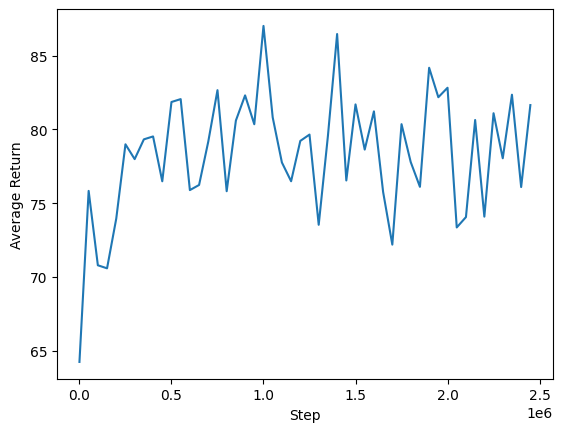

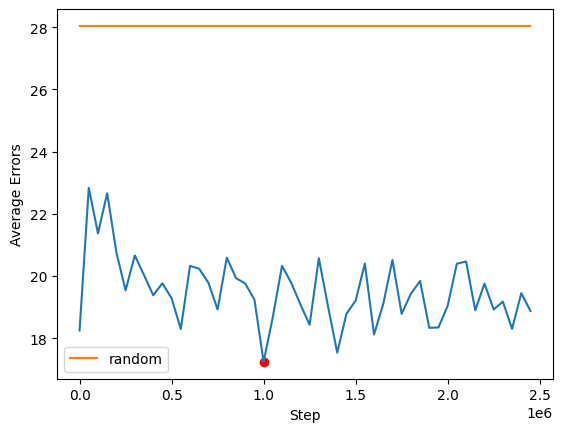

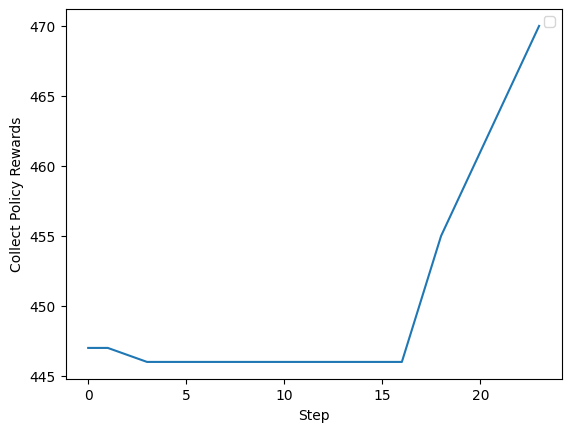

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

scenario (2, 6)
scenario (8, 15)
scenario (15, 7)
scenario (9, 16)
scenario (6, 4)
scenario (15, 18)
scenario (12, 19)
scenario (8, 10)
scenario (14, 6)
scenario (2, 10)
scenario (14, 13)
scenario (1, 6)
scenario (12, 6)
scenario (12, 11)
scenario (7, 0)
scenario (8, 2)
scenario (5, 22)
scenario (14, 17)
scenario (2, 1)
scenario (7, 3)
scenario (6, 19)
scenario (1, 1)
scenario (7, 15)
scenario (5, 13)
scenario (4, 11)
scenario (3, 19)
scenario (11, 1)
scenario (2, 8)
scenario (3, 21)
scenario (12, 15)
scenario (5, 9)
scenario (4, 11)
scenario (7, 19)
scenario (3, 5)
scenario (10, 10)
scenario (3, 1)
scenario (8, 12)
scenario (11, 12)
scenario (10, 16)
scenario (6, 0)
scenario (12, 12)
scenario (1, 9)
scenario (7, 2)
scenario (8, 3)
scenario (11, 11)
scenario (10, 15)
scenario (15, 18)
scenario (15, 2)
scenario (1, 18)
scenario (11, 4)
scenario (7, 14)
scenario (9, 5)
scenario (9, 2)
scenario (2, 11)
scenario (13, 5)
scenario (9, 2)
scenario (11, 10)
scenario (15, 16)
scenario (6, 18)
s

In [27]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

22.880813233971597 17.32362817143133


In [28]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [29]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

22.600406259298325 17.44717700462062


In [30]:
saved_policy = tf.saved_model.load(train_log_dir)
#saved_policy = tf.saved_model.load("./models/RL/2023-06-09--00:06:51")
avg_return, avg_error, all_errors = compute_avg_return(eval_py_env, saved_policy, n_agents, 500, batched = True)
print(avg_return, avg_error, np.median(all_errors))

22.860212488889694 17.20865440512702 15.534094978010408
